In [1]:
import torch
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from xlmr_culture_classification import XLMRCultureClassifier, XLMRCultureClassifier_2
from transformers import  XLMRobertaTokenizerFast
from datasets import Dataset
from transformers import AdamW
from transformers import XLMRobertaTokenizerFast, XLMRobertaForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import numpy as np
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import json

from transformers import  DataCollatorForTokenClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import warnings
import pandas as pd
import csv


c:\coding\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

##### General set up

In [3]:
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

In [4]:
# cultural_train = "data/train_merged_output.conll"
cultural_train = "annotation/test/fully_annotated_span_test_lyrics.conll"
# cultural_test = "data/test_merged_output.conll"
cultural_test = "annotation/train/fully_annotated_lyrics_span.conll"

In [ ]:
def extract_refs(json_path):
    cultural_refs_tag = []
    cultural_refs_IDs = {}

    with open(json_path, "r") as f:
        cultural_data = json.load(f)
        cultural_refs_tag.extend([entry['tag'] for entry in cultural_data])
        cultural_refs_IDs.update({entry['tag']: entry['id'] for entry in cultural_data})

    return cultural_refs_tag, cultural_refs_IDs

ner_tags_path = "data/ner_tags.json"
cultural_ref_tags_path = "data/cultural_tags.json"

ner_tags, tag2id_ner = extract_refs(ner_tags_path)
cultural_tags, tag2id_cultural = extract_refs(cultural_ref_tags_path)

num_labels_culture = len(tag2id_cultural)
num_labels_ner = len(tag2id_ner)

In [6]:
ner_tags_path = "data/ner_tags.json"
cultural_ref_tags_path = "data/cultural_tags.json"

ner_tags, tag2id_ner = extract_refs(ner_tags_path)
cultural_tags, tag2id_cultural = extract_refs(cultural_ref_tags_path)

id2tag_ner = {v: k for k, v in tag2id_ner.items()}
id2tag_cultural = {v: k for k, v in tag2id_cultural.items()}

In [7]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")    
#     print('There are %d GPU(s) available.' % torch.cuda.device_count())
#     print('GPU is:', torch.cuda.get_device_name(0))
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [8]:
tag2id_cultural

{'-': 0,
 'African': 1,
 'North American': 2,
 'Eastern Asian': 3,
 'European': 4,
 'Latin': 5,
 'Middle Asian': 6,
 'Middle Eastern': 7,
 'Oceanian': 8,
 'Non cultural': 9}

In [9]:
id2tag_cultural

{0: '-',
 1: 'African',
 2: 'North American',
 3: 'Eastern Asian',
 4: 'European',
 5: 'Latin',
 6: 'Middle Asian',
 7: 'Middle Eastern',
 8: 'Oceanian',
 9: 'Non cultural'}

##### Vizualizations

In [10]:
header = {0:'token', 1:'ner_tag', 2:'cultural_tag'}

chunksize = 100000
chunks = []  # List to store chunks

In [11]:
chunks = pd.read_csv(cultural_train, encoding='utf-8', sep='\t', engine='python', on_bad_lines='skip', header=None, low_memory=True,chunksize=chunksize)

In [12]:
chunks = pd.read_csv(
    cultural_train,
    encoding='utf-8',
    sep='\t',
    engine='python',
    on_bad_lines='skip',
    header=None,
    quoting=csv.QUOTE_NONE,
    chunksize=100000,
    low_memory=True
)


In [13]:
df = pd.concat(chunks, ignore_index=True)

In [14]:
df.rename(columns=header)

,token,ner_tag,cultural_tag
0,Desfilaba,O,-
1,en,O,-
2,Milán,B-LOC,European
3,Con,O,-
4,21,B-MISC,European
...,...,...,...
3082,religión,O,-
3083,Real,O,-
3084,hasta,O,-
3085,la,O,-


In [15]:
exclude = ['-']
filtered_cult = df[~df[2].isin(exclude)]

In [16]:
filtered_cult

,0,1,2
2,Milán,B-LOC,European
4,21,B-MISC,European
8,Prada,B-ORG,European
59,Berlín,B-LOC,European
62,techno,B-MISC,Non-cultural
...,...,...,...
3055,Que,I-MISC,Latin
3056,Me,I-MISC,Latin
3057,De,I-MISC,Latin
3058,La,I-MISC,Latin


<AxesSubplot: xlabel='2'>

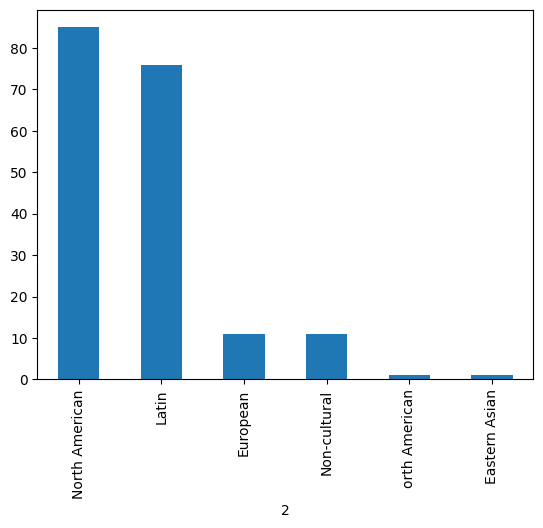

In [17]:
filtered_cult[2].value_counts().plot.bar()
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
#imbalanced data for training


In [18]:
exclude = ['O']
filtered_ner = df[~df[1].isin(exclude)]

<AxesSubplot: xlabel='1'>

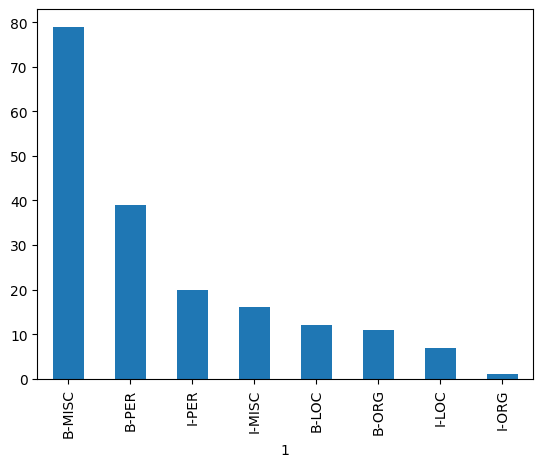

In [19]:
filtered_ner[1].value_counts().plot.bar()

#### Data aligment

In [20]:
def parse_conllu(file_path):
    " This function create a usable dataset of the sparse .conllu file with the NER tags and cultural refferences"
    sentences = []
    tags = []
    cultural_references = []
    
    with open(file_path, "r",encoding="utf-8") as file:
        tokens = []
        ner_tags = []
        cultural_ref = []
        
        for line in file:
            line = line.strip()
                       
            if not line:
                if tokens:  
                    sentences.append(tokens)
                    tags.append(ner_tags)
                    cultural_references.append(cultural_ref)
              
                tokens = []
                ner_tags = []
                cultural_ref = []
                continue

            parts = line.split("\t")
            
            if len(parts) >= 3:
                token = parts[0]  
                ner_tag = parts[1] 
                cultural_ref_val = parts[2]
                
                tokens.append(token)
                ner_tags.append(ner_tag)
                cultural_ref.append(cultural_ref_val)
        
       
        if tokens:
            sentences.append(tokens)
            tags.append(ner_tags)
            cultural_references.append(cultural_ref)
    
    return sentences, tags, cultural_references

In [21]:
sentences, tags, cultural_refs = parse_conllu(cultural_train)
train_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences, tags, cultural_refs)]
dataset_train = Dataset.from_list(train_data)

In [22]:
#load test data for later use:
sentences_test, tags_test, cultural_refs_test = parse_conllu(cultural_test)
test_data = [{"tokens": s, "ner_tags": t, "cultural_ref": c} for s, t, c in zip(sentences_test, tags_test, cultural_refs_test)]
dataset_test = Dataset.from_list(test_data)

In [23]:
dataset = dataset_train.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

In [24]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'cultural_ref'],
    num_rows: 317
})

In [25]:
def tokenize_and_align_labels_with_cultural(example):
    tokenized = tokenizer(
        example['tokens'], 
        truncation=True, 
        padding=True,
        is_split_into_words=True
    )

    labels = []
    cultural_ref = []

    for i, word in enumerate(example['tokens']):
        if example['ner_tags'][i] != "O":
            
            labels.append(tag2id_ner.get(example['ner_tags'][i], -100))
            
            cultural_ref.append(tag2id_cultural.get(example['cultural_ref'][i], -100))
        else:
            labels.append(-100)
            cultural_ref.append(-100)

    tokenized['labels'] = labels
    tokenized['cultural_ref'] = cultural_ref
    return tokenized


In [26]:
tokenized_cultural_train = train_dataset.map(tokenize_and_align_labels_with_cultural)
tokenized_cultural_val = val_dataset.map(tokenize_and_align_labels_with_cultural)


In [27]:
tokenized_cultural_test = dataset_test.map(tokenize_and_align_labels_with_cultural)

In [28]:
print(tokenized_cultural_train[7]['input_ids'])
print(tokenized_cultural_train[7]['labels'])


[0, 1208, 151250, 11, 163, 479, 6967, 5627, 41, 10, 13042, 163, 36268, 402, 2]
[-100, -100, -100, -100, -100, -100, -100, -100, -100]


In [29]:
# tokenized_cultural_train[7]

In [30]:
for i in range(3):
    tokens = tokenizer.convert_ids_to_tokens(tokenized_cultural_train[i]['input_ids'])
    labels = [id2tag_cultural.get(id, "IGN") for id in tokenized_cultural_train[i]['labels']]
    print(list(zip(tokens, labels)))

[('<s>', 'IGN'), ('▁Extra', 'IGN'), ('▁', 'IGN'), (',', 'IGN'), ('▁extra', 'IGN'), ('▁', 'IGN'), (',', 'IGN'), ('▁mi', 'IGN')]
[('<s>', 'IGN'), ('▁¿', 'IGN'), ('▁Te', 'IGN'), ('▁cree', 'European'), ('s', 'Oceanian'), ('▁Brad', 'IGN'), ('▁Pitt', 'IGN'), ('▁?', 'IGN'), ('▁¿', 'IGN'), ('▁Ah', 'IGN'), ('▁', 'IGN')]
[('<s>', 'IGN'), ('▁De', 'IGN'), ('mu', 'IGN'), ('e', 'IGN'), ('stra', 'IGN'), ('▁má', 'IGN'), ("'", 'IGN'), ('▁respeto', 'IGN'), ('▁', 'IGN'), (',', 'IGN')]


#### Model set up

In [31]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [32]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2tag_cultural[p] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag_cultural[l] for (p, l) in zip(pred, label) if l != -100]
        for pred, label in zip(predictions, labels)
    ]

    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

##### Model version 1

In [33]:
# #addign class weights
# all_labels = [
#     label for seq in tokenized_cultural_train['labels']
#     for label in seq if label != -100]

# train_labels_present = np.unique(all_labels)

# class_weights_raw = compute_class_weight(class_weight="balanced", classes=train_labels_present, y=all_labels)

# full_class_weights = torch.ones(len(id2tag_cultural), dtype=torch.float)

# # Add all class weights, as some of them are not present in the training set
# for i, label in enumerate(train_labels_present):
#     full_class_weights[label] = class_weights_raw[i]


In [34]:
# culture_model = XLMRCultureClassifier(num_labels_culture,class_weights=full_class_weights)
# optimizer = AdamW(culture_model.parameters(), lr=5e-5)

In [35]:
# #cult model 1
# training_args = TrainingArguments(
#     output_dir="./xlmr-cultural-model",
#     save_strategy="steps",
#     save_steps=50,
#     evaluation_strategy="steps",
#     eval_steps=25,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     logging_dir="./logs",
#     logging_steps=10,
#     learning_rate=3e-5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     max_grad_norm=1.0,
#     save_total_limit=2,
#     remove_unused_columns=True,
#     fp16=False,
# )

# trainer = Trainer(
#     model=culture_model,
#     args=training_args,
#     train_dataset=tokenized_cultural_train,
#     eval_dataset=tokenized_cultural_val,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=data_collator,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
# )


##### Model version 2

In [36]:
# culture_model_2 = XLMRCultureClassifier_2(num_labels_culture,class_weights=full_class_weights)
# optimizer = AdamW(culture_model_2.parameters(), lr=5e-5)

In [37]:
# #Alternative classifier
# training_args_2 = TrainingArguments(
#     output_dir="./xlmr-cultural-model_2",
#     save_strategy="steps",
#     save_steps=50,
#     evaluation_strategy="steps",
#     eval_steps=25,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     logging_dir="./logs",
#     logging_steps=10,
#     learning_rate=3e-5,
#     per_device_train_batch_size=64,
#     per_device_eval_batch_size=64,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     max_grad_norm=1.0,
#     save_total_limit=2,
#     remove_unused_columns=True,
#     fp16=False,
# )

# trainer_2 = Trainer(
#     model=culture_model_2,
#     args=training_args_2,
#     train_dataset=tokenized_cultural_train,
#     eval_dataset=tokenized_cultural_val,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=data_collator,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

##### Final model (ver3.)

In [38]:
num_labels_culture

10

In [39]:
model_funziez = XLMRobertaForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=num_labels_culture,
    id2label=id2tag_cultural,
    label2id=tag2id_cultural)

optimizer = AdamW(model_funziez.parameters(), lr=5e-5)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to us

In [40]:
training_args_fun = TrainingArguments(
    output_dir="./xlmr-cultural-funziez",
    save_strategy="steps",
    save_steps=50,
    evaluation_strategy="steps",
    eval_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs",
    logging_steps=25,
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    max_grad_norm=1.0,
    save_total_limit=2,
    remove_unused_columns=True,
    fp16=False,
)

trainer_fun = Trainer(
    model=model_funziez,
    args=training_args_fun,
    train_dataset=tokenized_cultural_train,
    eval_dataset=tokenized_cultural_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)

In [41]:
trainer_fun.train()

  4%|▍         | 2/50 [00:18<07:41,  9.61s/it]

KeyboardInterrupt: 

##### Model training and evaluation

##### 1.

In [ ]:
# trainer.train()

                                                  

  1%|          | 10/820 [01:21<2:00:04,  8.89s/it]


{'loss': 2.3073, 'learning_rate': 2.9634146341463413e-05, 'epoch': 0.12}


                                                  

  2%|▏         | 20/820 [02:46<1:55:21,  8.65s/it]


{'loss': 2.1902, 'learning_rate': 2.926829268292683e-05, 'epoch': 0.24}


  3%|▎         | 25/820 [03:27<1:50:03,  8.31s/it]
                                                  

  3%|▎         | 25/820 [03:48<1:50:03,  8.31s/it]


{'eval_loss': 2.0956010818481445, 'eval_precision': 0.16748768472906403, 'eval_recall': 0.19318181818181818, 'eval_f1': 0.17941952506596306, 'eval_runtime': 21.5287, 'eval_samples_per_second': 26.941, 'eval_steps_per_second': 0.464, 'epoch': 0.3}


                                                  

  4%|▎         | 30/820 [04:25<1:56:16,  8.83s/it]


{'loss': 2.153, 'learning_rate': 2.8902439024390242e-05, 'epoch': 0.37}


                                                  

  5%|▍         | 40/820 [05:43<1:41:48,  7.83s/it]


{'loss': 1.9614, 'learning_rate': 2.8536585365853658e-05, 'epoch': 0.49}


                                                  

  6%|▌         | 50/820 [07:27<2:54:57, 13.63s/it]


{'loss': 2.0341, 'learning_rate': 2.817073170731707e-05, 'epoch': 0.61}



                                                  

  6%|▌         | 50/820 [07:48<2:54:57, 13.63s/it]


{'eval_loss': 1.7043747901916504, 'eval_precision': 0.2949640287769784, 'eval_recall': 0.23295454545454544, 'eval_f1': 0.2603174603174603, 'eval_runtime': 21.1508, 'eval_samples_per_second': 27.422, 'eval_steps_per_second': 0.473, 'epoch': 0.61}


                                                  

  7%|▋         | 60/820 [09:12<1:43:12,  8.15s/it]


{'loss': 1.8709, 'learning_rate': 2.780487804878049e-05, 'epoch': 0.73}


                                                  

  9%|▊         | 70/820 [10:33<1:39:59,  8.00s/it]


{'loss': 1.773, 'learning_rate': 2.7439024390243903e-05, 'epoch': 0.85}


  9%|▉         | 75/820 [11:13<1:40:13,  8.07s/it]
                                                  

  9%|▉         | 75/820 [11:33<1:40:13,  8.07s/it]


{'eval_loss': 1.5018389225006104, 'eval_precision': 0.48026315789473684, 'eval_recall': 0.4147727272727273, 'eval_f1': 0.4451219512195122, 'eval_runtime': 20.8263, 'eval_samples_per_second': 27.849, 'eval_steps_per_second': 0.48, 'epoch': 0.91}


                                                  

 10%|▉         | 80/820 [12:15<1:58:38,  9.62s/it]


{'loss': 1.6891, 'learning_rate': 2.707317073170732e-05, 'epoch': 0.98}


                                                  

 11%|█         | 90/820 [13:38<1:54:15,  9.39s/it]


{'loss': 1.613, 'learning_rate': 2.6707317073170732e-05, 'epoch': 1.1}


                                                   

 12%|█▏        | 100/820 [14:55<1:32:34,  7.71s/it]


{'loss': 1.5083, 'learning_rate': 2.6341463414634148e-05, 'epoch': 1.22}



                                                   

 12%|█▏        | 100/820 [15:16<1:32:34,  7.71s/it]


{'eval_loss': 1.5170347690582275, 'eval_precision': 0.39473684210526316, 'eval_recall': 0.3409090909090909, 'eval_f1': 0.36585365853658536, 'eval_runtime': 21.4859, 'eval_samples_per_second': 26.994, 'eval_steps_per_second': 0.465, 'epoch': 1.22}


                                                   

 13%|█▎        | 110/820 [16:47<1:33:01,  7.86s/it]


{'loss': 1.4688, 'learning_rate': 2.597560975609756e-05, 'epoch': 1.34}


                                                   

 15%|█▍        | 120/820 [18:03<1:28:19,  7.57s/it]


{'loss': 1.3801, 'learning_rate': 2.5609756097560977e-05, 'epoch': 1.46}


 15%|█▌        | 125/820 [18:48<1:47:24,  9.27s/it]
                                                   

 15%|█▌        | 125/820 [19:09<1:47:24,  9.27s/it]


{'eval_loss': 1.3019108772277832, 'eval_precision': 0.6012658227848101, 'eval_recall': 0.5397727272727273, 'eval_f1': 0.5688622754491018, 'eval_runtime': 21.2401, 'eval_samples_per_second': 27.307, 'eval_steps_per_second': 0.471, 'epoch': 1.52}


                                                   

 16%|█▌        | 130/820 [19:47<1:48:08,  9.40s/it]


{'loss': 1.136, 'learning_rate': 2.524390243902439e-05, 'epoch': 1.59}


                                                   

 17%|█▋        | 140/820 [21:07<1:34:39,  8.35s/it]


{'loss': 1.0874, 'learning_rate': 2.4878048780487805e-05, 'epoch': 1.71}


                                                   

 18%|█▊        | 150/820 [22:29<1:34:38,  8.48s/it]


{'loss': 1.2792, 'learning_rate': 2.4512195121951218e-05, 'epoch': 1.83}



                                                   

 18%|█▊        | 150/820 [22:51<1:34:38,  8.48s/it]


{'eval_loss': 1.107533574104309, 'eval_precision': 0.6433566433566433, 'eval_recall': 0.5227272727272727, 'eval_f1': 0.5768025078369905, 'eval_runtime': 22.2294, 'eval_samples_per_second': 26.092, 'eval_steps_per_second': 0.45, 'epoch': 1.83}


                                                   

 20%|█▉        | 160/820 [24:19<1:29:48,  8.16s/it]


{'loss': 1.1622, 'learning_rate': 2.4146341463414638e-05, 'epoch': 1.95}


                                                   

 21%|██        | 170/820 [26:14<1:48:16,  9.99s/it]


{'loss': 1.2122, 'learning_rate': 2.378048780487805e-05, 'epoch': 2.07}


 21%|██▏       | 175/820 [26:52<1:28:37,  8.24s/it]
                                                   

 21%|██▏       | 175/820 [27:13<1:28:37,  8.24s/it]


{'eval_loss': 1.1049326658248901, 'eval_precision': 0.6463414634146342, 'eval_recall': 0.6022727272727273, 'eval_f1': 0.6235294117647059, 'eval_runtime': 21.2386, 'eval_samples_per_second': 27.309, 'eval_steps_per_second': 0.471, 'epoch': 2.13}


                                                   

 22%|██▏       | 180/820 [27:52<1:39:24,  9.32s/it]


{'loss': 0.9894, 'learning_rate': 2.3414634146341466e-05, 'epoch': 2.2}


                                                   

 23%|██▎       | 190/820 [29:12<1:25:44,  8.17s/it]


{'loss': 1.0245, 'learning_rate': 2.304878048780488e-05, 'epoch': 2.32}


                                                   

 24%|██▍       | 200/820 [30:29<1:27:49,  8.50s/it]


{'loss': 1.036, 'learning_rate': 2.2682926829268295e-05, 'epoch': 2.44}



                                                   

 24%|██▍       | 200/820 [30:50<1:27:49,  8.50s/it]


{'eval_loss': 1.0629382133483887, 'eval_precision': 0.6357615894039735, 'eval_recall': 0.5454545454545454, 'eval_f1': 0.5871559633027522, 'eval_runtime': 21.4033, 'eval_samples_per_second': 27.099, 'eval_steps_per_second': 0.467, 'epoch': 2.44}


                                                   

 26%|██▌       | 210/820 [32:19<1:22:34,  8.12s/it]


{'loss': 0.9233, 'learning_rate': 2.2317073170731708e-05, 'epoch': 2.56}


                                                   

 27%|██▋       | 220/820 [33:35<1:19:52,  7.99s/it]


{'loss': 0.9033, 'learning_rate': 2.195121951219512e-05, 'epoch': 2.68}


 27%|██▋       | 225/820 [34:40<2:28:49, 15.01s/it]
                                                   

 27%|██▋       | 225/820 [35:02<2:28:49, 15.01s/it]


{'eval_loss': 0.9210220575332642, 'eval_precision': 0.6866666666666666, 'eval_recall': 0.5852272727272727, 'eval_f1': 0.6319018404907976, 'eval_runtime': 22.0734, 'eval_samples_per_second': 26.276, 'eval_steps_per_second': 0.453, 'epoch': 2.74}


                                                   

 28%|██▊       | 230/820 [35:43<1:43:36, 10.54s/it]


{'loss': 1.0125, 'learning_rate': 2.1585365853658537e-05, 'epoch': 2.8}


                                                   

 29%|██▉       | 240/820 [37:01<1:09:57,  7.24s/it]


{'loss': 0.8462, 'learning_rate': 2.121951219512195e-05, 'epoch': 2.93}


                                                   

 30%|███       | 250/820 [38:21<1:14:38,  7.86s/it]


{'loss': 0.8485, 'learning_rate': 2.0853658536585365e-05, 'epoch': 3.05}



                                                   

 30%|███       | 250/820 [38:42<1:14:38,  7.86s/it]


{'eval_loss': 0.887202799320221, 'eval_precision': 0.725609756097561, 'eval_recall': 0.6761363636363636, 'eval_f1': 0.7, 'eval_runtime': 21.2553, 'eval_samples_per_second': 27.287, 'eval_steps_per_second': 0.47, 'epoch': 3.05}


                                                   

 32%|███▏      | 260/820 [40:15<1:17:40,  8.32s/it]


{'loss': 0.7637, 'learning_rate': 2.048780487804878e-05, 'epoch': 3.17}


                                                   

 33%|███▎      | 270/820 [41:41<1:21:10,  8.86s/it]


{'loss': 0.6272, 'learning_rate': 2.0121951219512197e-05, 'epoch': 3.29}


 34%|███▎      | 275/820 [42:19<1:10:45,  7.79s/it]
                                                   

 34%|███▎      | 275/820 [42:40<1:10:45,  7.79s/it]


{'eval_loss': 1.0586938858032227, 'eval_precision': 0.7409638554216867, 'eval_recall': 0.6988636363636364, 'eval_f1': 0.7192982456140351, 'eval_runtime': 21.1736, 'eval_samples_per_second': 27.393, 'eval_steps_per_second': 0.472, 'epoch': 3.35}


                                                   

 34%|███▍      | 280/820 [43:20<1:28:46,  9.86s/it]


{'loss': 0.4816, 'learning_rate': 1.975609756097561e-05, 'epoch': 3.41}


                                                   

 35%|███▌      | 290/820 [44:37<1:07:13,  7.61s/it]


{'loss': 0.6566, 'learning_rate': 1.9390243902439026e-05, 'epoch': 3.54}


                                                   

 37%|███▋      | 300/820 [46:17<1:43:30, 11.94s/it]


{'loss': 0.7149, 'learning_rate': 1.902439024390244e-05, 'epoch': 3.66}



                                                   

 37%|███▋      | 300/820 [46:38<1:43:30, 11.94s/it]


{'eval_loss': 1.0093684196472168, 'eval_precision': 0.7692307692307693, 'eval_recall': 0.6818181818181818, 'eval_f1': 0.7228915662650602, 'eval_runtime': 21.4231, 'eval_samples_per_second': 27.074, 'eval_steps_per_second': 0.467, 'epoch': 3.66}


                                                   

 38%|███▊      | 310/820 [48:07<1:12:47,  8.56s/it]


{'loss': 0.5693, 'learning_rate': 1.8658536585365855e-05, 'epoch': 3.78}


                                                   

 39%|███▉      | 320/820 [49:23<1:01:40,  7.40s/it]


{'loss': 0.5748, 'learning_rate': 1.8292682926829268e-05, 'epoch': 3.9}


 40%|███▉      | 325/820 [50:06<1:05:54,  7.99s/it]
                                                   

 40%|███▉      | 325/820 [50:27<1:05:54,  7.99s/it]


{'eval_loss': 1.0071289539337158, 'eval_precision': 0.738562091503268, 'eval_recall': 0.6420454545454546, 'eval_f1': 0.6869300911854104, 'eval_runtime': 21.5677, 'eval_samples_per_second': 26.892, 'eval_steps_per_second': 0.464, 'epoch': 3.96}


                                                   

 40%|███▉      | 325/820 [50:28<1:16:53,  9.32s/it]

{'train_runtime': 3028.852, 'train_samples_per_second': 17.208, 'train_steps_per_second': 0.271, 'train_loss': 1.2356011368678166, 'epoch': 3.96}


TrainOutput(global_step=325, training_loss=1.2356011368678166, metrics={'train_runtime': 3028.852, 'train_samples_per_second': 17.208, 'train_steps_per_second': 0.271, 'train_loss': 1.2356011368678166, 'epoch': 3.96})

In [ ]:
# # model 1
# outputs = trainer.predict(tokenized_cultural_test)

# preds = np.argmax(outputs.predictions, axis=2)
# labels = outputs.label_ids

In [ ]:
# eval_results = trainer.evaluate()

# print(eval_results)

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

{'eval_loss': 0.887202799320221, 'eval_precision': 0.725609756097561, 'eval_recall': 0.6761363636363636, 'eval_f1': 0.7, 'eval_runtime': 22.2691, 'eval_samples_per_second': 26.045, 'eval_steps_per_second': 0.449, 'epoch': 3.96}


In [ ]:
# trainer.evaluate(tokenized_cultural_test)

100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


{'eval_loss': nan,
 'eval_precision': 0.5006031363088058,
 'eval_recall': 0.45755237045203967,
 'eval_f1': 0.47811059907834097,
 'eval_runtime': 80.0257,
 'eval_samples_per_second': 39.7,
 'eval_steps_per_second': 0.625,
 'epoch': 3.96}

##### 2.

In [ ]:
# trainer_2.train()

                                                  

  1%|          | 10/820 [01:45<1:59:43,  8.87s/it]


{'loss': 1.8845, 'learning_rate': 2.9634146341463413e-05, 'epoch': 0.12}


                                                  

  2%|▏         | 20/820 [03:09<1:42:15,  7.67s/it]


{'loss': 1.8192, 'learning_rate': 2.926829268292683e-05, 'epoch': 0.24}


  3%|▎         | 25/820 [03:50<1:51:22,  8.41s/it]
                                                  

  3%|▎         | 25/820 [04:13<1:51:22,  8.41s/it]


{'eval_loss': 1.6193300485610962, 'eval_precision': 0.4385026737967914, 'eval_recall': 0.4659090909090909, 'eval_f1': 0.45179063360881544, 'eval_runtime': 22.9695, 'eval_samples_per_second': 25.251, 'eval_steps_per_second': 0.435, 'epoch': 0.3}


                                                  

  4%|▎         | 30/820 [04:53<2:09:01,  9.80s/it]


{'loss': 1.7529, 'learning_rate': 2.8902439024390242e-05, 'epoch': 0.37}


                                                  

  5%|▍         | 40/820 [06:10<1:45:53,  8.15s/it]


{'loss': 1.8201, 'learning_rate': 2.8536585365853658e-05, 'epoch': 0.49}


                                                  

  6%|▌         | 50/820 [07:27<1:35:37,  7.45s/it]


{'loss': 1.4578, 'learning_rate': 2.817073170731707e-05, 'epoch': 0.61}



                                                  

  6%|▌         | 50/820 [07:48<1:35:37,  7.45s/it]


{'eval_loss': 1.5869405269622803, 'eval_precision': 0.48186528497409326, 'eval_recall': 0.5284090909090909, 'eval_f1': 0.5040650406504066, 'eval_runtime': 20.9571, 'eval_samples_per_second': 27.676, 'eval_steps_per_second': 0.477, 'epoch': 0.61}


                                                  

  7%|▋         | 60/820 [09:30<1:47:17,  8.47s/it]


{'loss': 1.6424, 'learning_rate': 2.780487804878049e-05, 'epoch': 0.73}


                                                  

  9%|▊         | 70/820 [10:51<1:36:38,  7.73s/it] 


{'loss': 1.2649, 'learning_rate': 2.7439024390243903e-05, 'epoch': 0.85}


  9%|▉         | 75/820 [11:28<1:33:21,  7.52s/it]
                                                  

  9%|▉         | 75/820 [11:49<1:33:21,  7.52s/it] 


{'eval_loss': 1.7729898691177368, 'eval_precision': 0.5460122699386503, 'eval_recall': 0.5056818181818182, 'eval_f1': 0.5250737463126843, 'eval_runtime': 21.3317, 'eval_samples_per_second': 27.19, 'eval_steps_per_second': 0.469, 'epoch': 0.91}


                                                  

 10%|▉         | 80/820 [12:30<1:53:11,  9.18s/it] 


{'loss': 1.643, 'learning_rate': 2.707317073170732e-05, 'epoch': 0.98}


                                                  

 11%|█         | 90/820 [13:46<1:39:39,  8.19s/it] 


{'loss': 1.1514, 'learning_rate': 2.6707317073170732e-05, 'epoch': 1.1}


                                                   

 12%|█▏        | 100/820 [15:05<1:30:14,  7.52s/it]


{'loss': 1.2778, 'learning_rate': 2.6341463414634148e-05, 'epoch': 1.22}



                                                   

 12%|█▏        | 100/820 [15:26<1:30:14,  7.52s/it]


{'eval_loss': 1.5557398796081543, 'eval_precision': 0.4269005847953216, 'eval_recall': 0.4147727272727273, 'eval_f1': 0.42074927953890495, 'eval_runtime': 21.3863, 'eval_samples_per_second': 27.12, 'eval_steps_per_second': 0.468, 'epoch': 1.22}


                                                   

 13%|█▎        | 110/820 [17:09<1:40:28,  8.49s/it]


{'loss': 1.0816, 'learning_rate': 2.597560975609756e-05, 'epoch': 1.34}


                                                   

 15%|█▍        | 120/820 [18:31<1:32:09,  7.90s/it]


{'loss': 1.0203, 'learning_rate': 2.5609756097560977e-05, 'epoch': 1.46}


 15%|█▌        | 125/820 [19:10<1:28:20,  7.63s/it]
                                                   

 15%|█▌        | 125/820 [19:31<1:28:20,  7.63s/it]


{'eval_loss': 1.4977682828903198, 'eval_precision': 0.5284090909090909, 'eval_recall': 0.5284090909090909, 'eval_f1': 0.5284090909090909, 'eval_runtime': 21.187, 'eval_samples_per_second': 27.375, 'eval_steps_per_second': 0.472, 'epoch': 1.52}


                                                   

 16%|█▌        | 130/820 [20:08<1:42:39,  8.93s/it]


{'loss': 1.2991, 'learning_rate': 2.524390243902439e-05, 'epoch': 1.59}


                                                   

 17%|█▋        | 140/820 [21:24<1:24:23,  7.45s/it]


{'loss': 1.0951, 'learning_rate': 2.4878048780487805e-05, 'epoch': 1.71}


                                                   

 18%|█▊        | 150/820 [23:04<1:33:26,  8.37s/it]


{'loss': 0.9884, 'learning_rate': 2.4512195121951218e-05, 'epoch': 1.83}



                                                   

 18%|█▊        | 150/820 [23:25<1:33:26,  8.37s/it]


{'eval_loss': 1.6861621141433716, 'eval_precision': 0.5536723163841808, 'eval_recall': 0.5568181818181818, 'eval_f1': 0.5552407932011332, 'eval_runtime': 21.0223, 'eval_samples_per_second': 27.59, 'eval_steps_per_second': 0.476, 'epoch': 1.83}


                                                   

 20%|█▉        | 160/820 [24:51<1:31:19,  8.30s/it]


{'loss': 1.361, 'learning_rate': 2.4146341463414638e-05, 'epoch': 1.95}


                                                   

 21%|██        | 170/820 [26:04<1:27:53,  8.11s/it]


{'loss': 0.8996, 'learning_rate': 2.378048780487805e-05, 'epoch': 2.07}


 21%|██▏       | 175/820 [26:43<1:24:06,  7.82s/it]
                                                   

 21%|██▏       | 175/820 [27:04<1:24:06,  7.82s/it]


{'eval_loss': 1.3107378482818604, 'eval_precision': 0.6497175141242938, 'eval_recall': 0.6534090909090909, 'eval_f1': 0.651558073654391, 'eval_runtime': 21.1089, 'eval_samples_per_second': 27.477, 'eval_steps_per_second': 0.474, 'epoch': 2.13}


                                                   

 22%|██▏       | 180/820 [27:41<1:37:37,  9.15s/it]


{'loss': 0.7833, 'learning_rate': 2.3414634146341466e-05, 'epoch': 2.2}


                                                   

 23%|██▎       | 190/820 [29:08<1:35:28,  9.09s/it]


{'loss': 0.6966, 'learning_rate': 2.304878048780488e-05, 'epoch': 2.32}


                                                   

 24%|██▍       | 200/820 [30:27<1:18:29,  7.60s/it]


{'loss': 0.9435, 'learning_rate': 2.2682926829268295e-05, 'epoch': 2.44}



                                                   

 24%|██▍       | 200/820 [30:48<1:18:29,  7.60s/it]


{'eval_loss': 1.4913442134857178, 'eval_precision': 0.6043956043956044, 'eval_recall': 0.625, 'eval_f1': 0.6145251396648044, 'eval_runtime': 21.0491, 'eval_samples_per_second': 27.555, 'eval_steps_per_second': 0.475, 'epoch': 2.44}


                                                   

 26%|██▌       | 210/820 [32:15<1:22:04,  8.07s/it]


{'loss': 0.772, 'learning_rate': 2.2317073170731708e-05, 'epoch': 2.56}


                                                   

 27%|██▋       | 220/820 [33:55<2:11:16, 13.13s/it]


{'loss': 0.7951, 'learning_rate': 2.195121951219512e-05, 'epoch': 2.68}


 27%|██▋       | 225/820 [34:32<1:21:54,  8.26s/it]
                                                   

 27%|██▋       | 225/820 [34:53<1:21:54,  8.26s/it]


{'eval_loss': 1.2411545515060425, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.6363636363636364, 'eval_f1': 0.6511627906976744, 'eval_runtime': 21.1114, 'eval_samples_per_second': 27.473, 'eval_steps_per_second': 0.474, 'epoch': 2.74}


                                                   

 28%|██▊       | 230/820 [35:34<1:28:47,  9.03s/it]


{'loss': 0.6399, 'learning_rate': 2.1585365853658537e-05, 'epoch': 2.8}


                                                   

 29%|██▉       | 240/820 [36:55<1:30:41,  9.38s/it]


{'loss': 0.7508, 'learning_rate': 2.121951219512195e-05, 'epoch': 2.93}


                                                   

 30%|███       | 250/820 [38:17<1:15:26,  7.94s/it]


{'loss': 0.7128, 'learning_rate': 2.0853658536585365e-05, 'epoch': 3.05}



                                                   

 30%|███       | 250/820 [38:38<1:15:26,  7.94s/it]


{'eval_loss': 1.1215060949325562, 'eval_precision': 0.7455621301775148, 'eval_recall': 0.7159090909090909, 'eval_f1': 0.7304347826086957, 'eval_runtime': 21.0497, 'eval_samples_per_second': 27.554, 'eval_steps_per_second': 0.475, 'epoch': 3.05}


                                                   

 32%|███▏      | 260/820 [40:15<1:18:43,  8.43s/it]


{'loss': 0.4304, 'learning_rate': 2.048780487804878e-05, 'epoch': 3.17}


                                                   

 33%|███▎      | 270/820 [41:35<1:10:59,  7.74s/it]


{'loss': 0.7027, 'learning_rate': 2.0121951219512197e-05, 'epoch': 3.29}


 34%|███▎      | 275/820 [42:11<1:06:27,  7.32s/it]
                                                   

 34%|███▎      | 275/820 [42:33<1:06:27,  7.32s/it]


{'eval_loss': 1.1212154626846313, 'eval_precision': 0.7087912087912088, 'eval_recall': 0.7329545454545454, 'eval_f1': 0.7206703910614525, 'eval_runtime': 21.8273, 'eval_samples_per_second': 26.572, 'eval_steps_per_second': 0.458, 'epoch': 3.35}


                                                   

 34%|███▍      | 280/820 [43:11<1:21:46,  9.09s/it]


{'loss': 0.4814, 'learning_rate': 1.975609756097561e-05, 'epoch': 3.41}


                                                   

 35%|███▌      | 290/820 [44:47<1:41:19, 11.47s/it]


{'loss': 0.3787, 'learning_rate': 1.9390243902439026e-05, 'epoch': 3.54}


                                                   

 37%|███▋      | 300/820 [45:59<1:06:45,  7.70s/it]


{'loss': 0.4293, 'learning_rate': 1.902439024390244e-05, 'epoch': 3.66}



                                                   

 37%|███▋      | 300/820 [46:20<1:06:45,  7.70s/it]


{'eval_loss': 1.2557510137557983, 'eval_precision': 0.7386363636363636, 'eval_recall': 0.7386363636363636, 'eval_f1': 0.7386363636363636, 'eval_runtime': 20.8948, 'eval_samples_per_second': 27.758, 'eval_steps_per_second': 0.479, 'epoch': 3.66}


                                                   

 38%|███▊      | 310/820 [47:55<1:13:39,  8.66s/it]


{'loss': 0.5814, 'learning_rate': 1.8658536585365855e-05, 'epoch': 3.78}


                                                   

 39%|███▉      | 320/820 [49:20<1:11:32,  8.58s/it]


{'loss': 0.3741, 'learning_rate': 1.8292682926829268e-05, 'epoch': 3.9}


 40%|███▉      | 325/820 [50:01<1:07:45,  8.21s/it]
                                                   

 40%|███▉      | 325/820 [50:22<1:07:45,  8.21s/it]


{'eval_loss': 1.2370688915252686, 'eval_precision': 0.7341040462427746, 'eval_recall': 0.7215909090909091, 'eval_f1': 0.7277936962750717, 'eval_runtime': 21.0003, 'eval_samples_per_second': 27.619, 'eval_steps_per_second': 0.476, 'epoch': 3.96}


                                                   

 40%|████      | 330/820 [50:56<1:11:53,  8.80s/it]


{'loss': 0.3959, 'learning_rate': 1.7926829268292684e-05, 'epoch': 4.02}


                                                   

 41%|████▏     | 340/820 [52:18<1:02:28,  7.81s/it]


{'loss': 0.2755, 'learning_rate': 1.7560975609756096e-05, 'epoch': 4.15}


                                                   

 43%|████▎     | 350/820 [53:39<1:03:15,  8.08s/it]


{'loss': 0.3384, 'learning_rate': 1.7195121951219512e-05, 'epoch': 4.27}



                                                   

 43%|████▎     | 350/820 [54:00<1:03:15,  8.08s/it]


{'eval_loss': 1.261083722114563, 'eval_precision': 0.7430167597765364, 'eval_recall': 0.7556818181818182, 'eval_f1': 0.7492957746478874, 'eval_runtime': 21.2516, 'eval_samples_per_second': 27.292, 'eval_steps_per_second': 0.471, 'epoch': 4.27}


                                                   

 43%|████▎     | 350/820 [54:10<1:12:44,  9.29s/it]

{'train_runtime': 3250.1584, 'train_samples_per_second': 16.036, 'train_steps_per_second': 0.252, 'train_loss': 0.9697421278272357, 'epoch': 4.27}


TrainOutput(global_step=350, training_loss=0.9697421278272357, metrics={'train_runtime': 3250.1584, 'train_samples_per_second': 16.036, 'train_steps_per_second': 0.252, 'train_loss': 0.9697421278272357, 'epoch': 4.27})

In [ ]:
# #model 2
# outputs_2 = trainer_2.predict(tokenized_cultural_test)

# preds_2 = np.argmax(outputs_2.predictions, axis=2)
# labels_2 = outputs_2.label_ids

100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


In [ ]:
# eval_results_2 = trainer_2.evaluate()

# print(eval_results_2)

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]

{'eval_loss': 1.1215060949325562, 'eval_precision': 0.7455621301775148, 'eval_recall': 0.7159090909090909, 'eval_f1': 0.7304347826086957, 'eval_runtime': 21.8242, 'eval_samples_per_second': 26.576, 'eval_steps_per_second': 0.458, 'epoch': 4.27}


In [ ]:
# trainer_2.evaluate(tokenized_cultural_test)

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


{'eval_loss': nan,
 'eval_precision': 0.2896551724137931,
 'eval_recall': 0.27783902976846747,
 'eval_f1': 0.28362408553742263,
 'eval_runtime': 79.4896,
 'eval_samples_per_second': 39.968,
 'eval_steps_per_second': 0.629,
 'epoch': 4.27}

##### 3.

In [ ]:
# model funziez
outputs_fun = trainer_fun.predict(tokenized_cultural_test)

preds_fun = np.argmax(outputs_fun.predictions, axis=2)
labels_fun = outputs_fun.label_ids

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


In [ ]:
eval_results_fun = trainer_fun.evaluate()

print(eval_results_fun)

100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

{'eval_loss': 0.5285700559616089, 'eval_precision': 0.8295454545454546, 'eval_recall': 0.8295454545454546, 'eval_f1': 0.8295454545454547, 'eval_runtime': 31.9174, 'eval_samples_per_second': 18.172, 'eval_steps_per_second': 0.313, 'epoch': 8.84}


In [ ]:
trainer_fun.evaluate(tokenized_cultural_test)

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


{'eval_loss': nan,
 'eval_precision': 0.5498812351543944,
 'eval_recall': 0.5104740904079382,
 'eval_f1': 0.5294453973699257,
 'eval_runtime': 97.4118,
 'eval_samples_per_second': 32.614,
 'eval_steps_per_second': 0.513,
 'epoch': 8.84}

#### Training loss and learning rate

##### 1.

In [ ]:
# #add path for model's LATEST checkpoint trainer_state.json
# trainer_state_path = "xlmr-cultural-model/checkpoint-300/trainer_state.json"

In [ ]:
# trainer_state_path_2 = "xlmr-cultural-model_2/checkpoint-350/trainer_state.json"

In [ ]:
def plot_training_logs(logs):

    steps = [log["step"] for log in logs if "loss" in log]
    train_loss = [log["loss"] for log in logs if "loss" in log]
    lr = [log["learning_rate"] for log in logs if "loss" in log]

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axs[0].plot(steps, train_loss, color='blue', label='Training Loss')
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(steps, lr, color='green', linestyle='--', label='Learning Rate')
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("LR")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

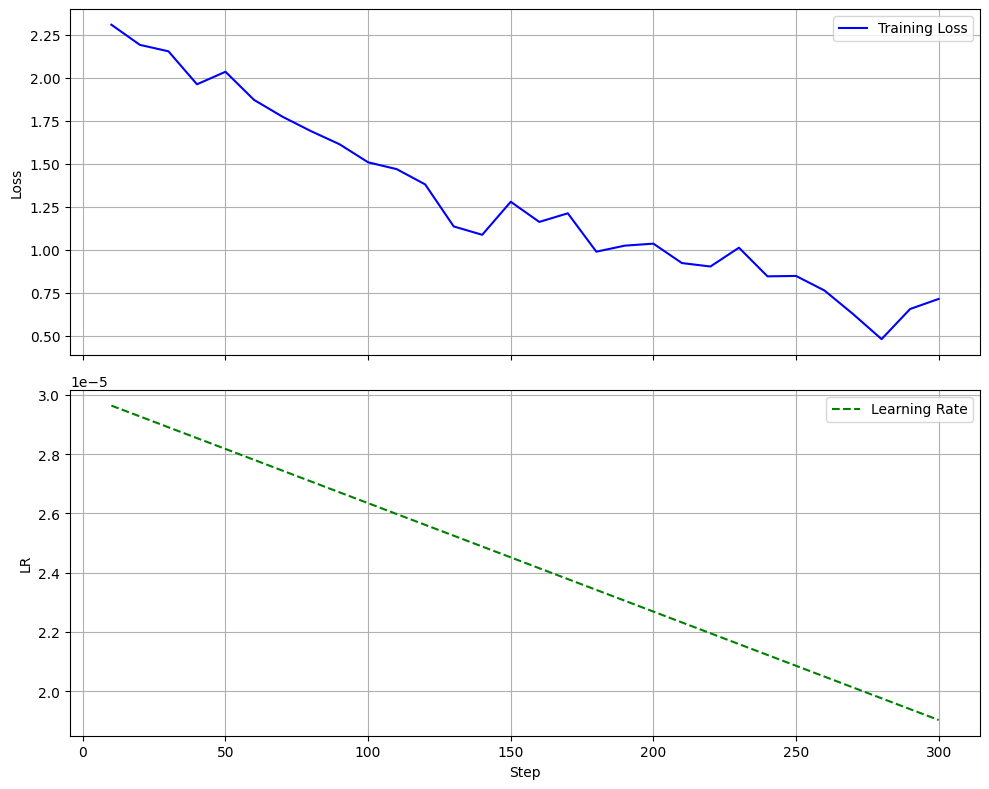

In [ ]:
# with open(trainer_state_path, "r") as f:
#     state = json.load(f)

# # Pass only the log history to the plotting function
# plot_training_logs(state["log_history"])
# # 

##### 2. 

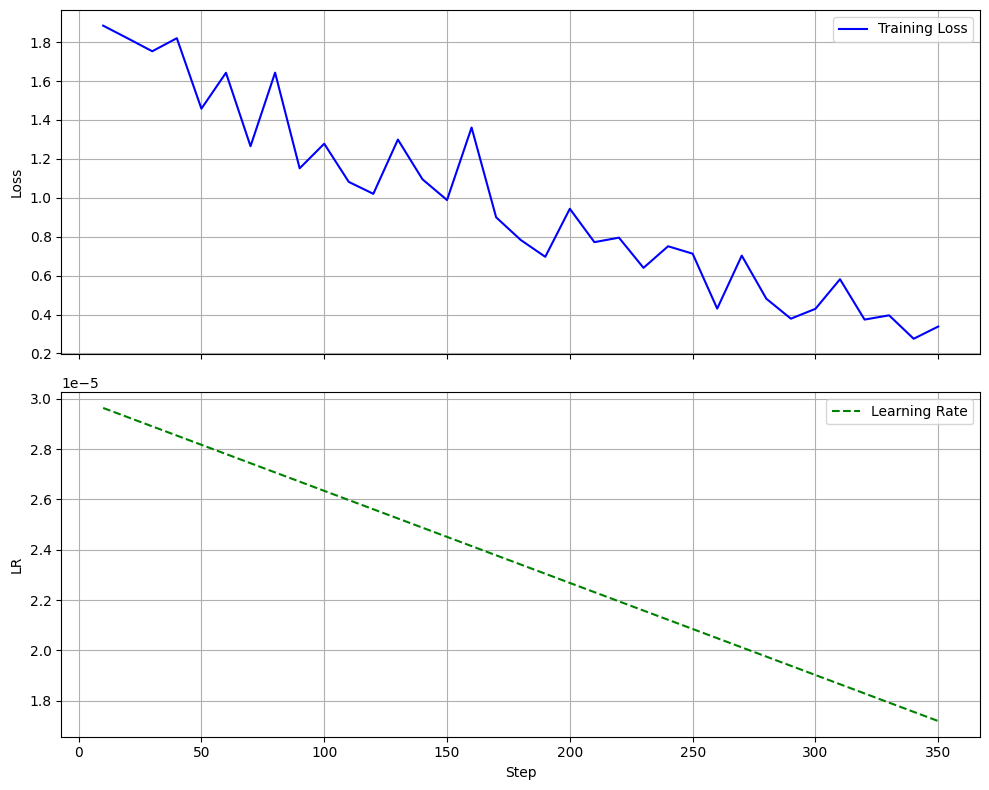

In [ ]:
# with open(trainer_state_path_2, "r") as f:
#     state_2 = json.load(f)

# # Pass only the log history to the plotting function
# plot_training_logs(state_2["log_history"])


##### 3.

In [ ]:
trainer_state_path_3 = "xlmr-cultural-funziez/checkpoint-700/trainer_state.json"

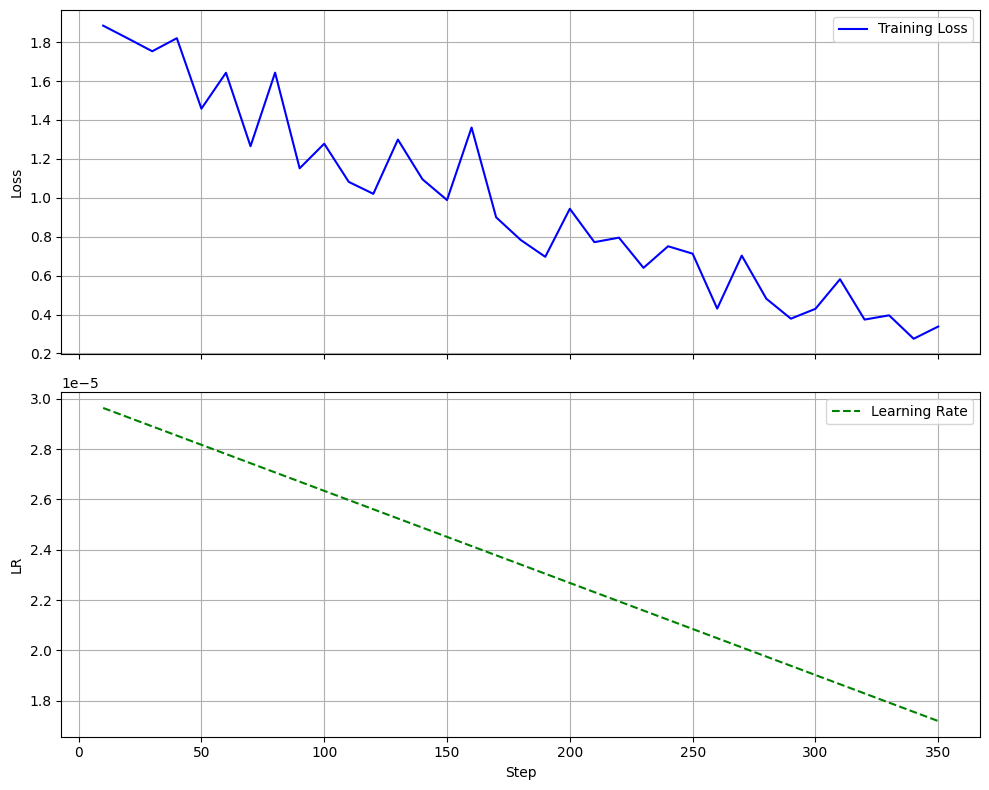

In [ ]:
with open(trainer_state_path_2, "r") as f:
    state_2 = json.load(f)

# Pass only the log history to the plotting function
plot_training_logs(state_2["log_history"])


#### Confusion matrix

##### 1.

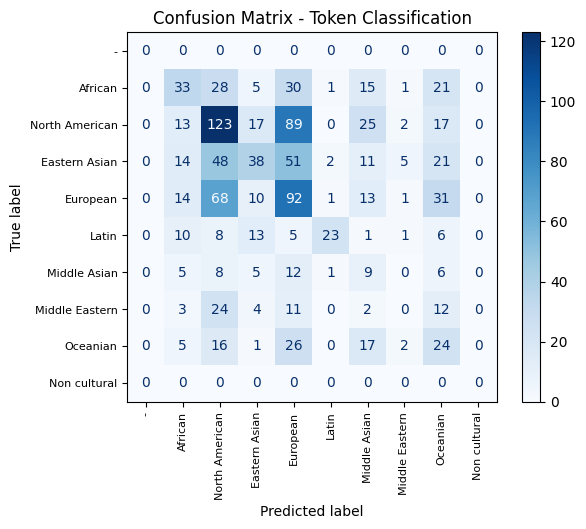

In [ ]:
# filtered = [(p, l) for pred, label in zip(preds_2, labels_2) for p, l in zip(pred, label) if l != -100]
# pred_labels, true_labels = zip(*filtered)
# pred_labels = list(pred_labels)
# true_labels = list(true_labels)


# # Confusion Matrix Calculation
# cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# # Mapping labels
# all_labels = list(id2tag_cultural.values())

# # Plotting the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Token Classification")
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
# plt.show()

##### 2.

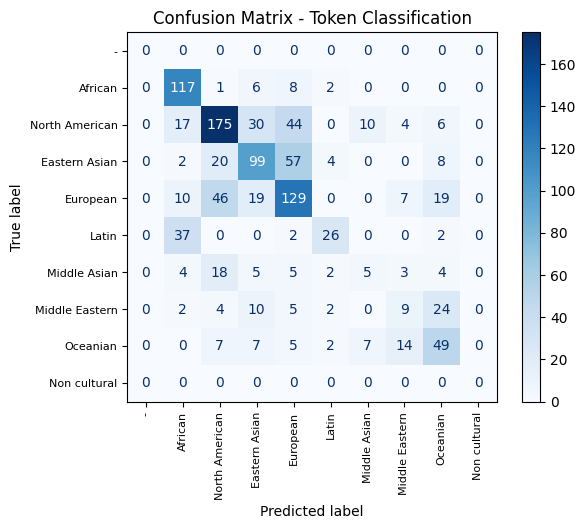

In [ ]:
# # Use list comprehension for better performance
# true_labels = [l for pred, label in zip(preds, labels) for p, l in zip(pred, label) if l != -100]
# pred_labels = [p for pred, label in zip(preds, labels) for p, l in zip(pred, label) if l != -100]

# # Confusion Matrix Calculation
# cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# # Mapping labels
# all_labels = list(id2tag_cultural.values())

# # Plotting the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Token Classification")
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
# plt.show()

##### 3. 

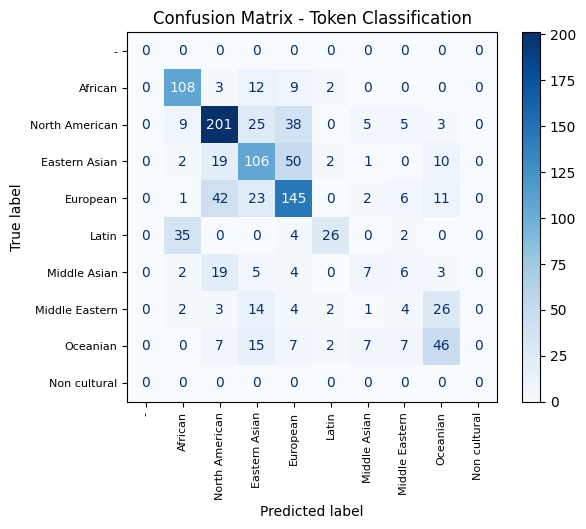

In [ ]:
# # Use list comprehension for better performance
# true_labels = [l for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]
# pred_labels = [p for pred, label in zip(preds_fun, labels_fun) for p, l in zip(pred, label) if l != -100]

# # Confusion Matrix Calculation
# cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(id2tag_cultural))))

# # Mapping labels
# all_labels = list(id2tag_cultural.values())

# # Plotting the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix - Token Classification")
# plt.xticks(fontsize=8, rotation=90)
# plt.yticks(fontsize=8)
# plt.show()